In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [3]:
X_tr, Y_tr = train_data.drop('label', axis=1).values, train_data['label'].values
X_val, Y_val = valid_data.drop('label', axis=1).values, valid_data['label'].values

In [4]:
X_tr = torch.tensor(X_tr, dtype=torch.float32) / 255.0
Y_tr = torch.tensor(Y_tr, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32) / 255.0
Y_val = torch.tensor(Y_val, dtype=torch.long)

In [5]:
input_size = X_tr.shape[1]
hidden_layer_1_size = 512
hidden_layer_2_size = 512
hidden_layer_3_size = 512
output_size = 10

In [6]:
import torch

import torch.nn as nn

# Define the sequential model
model = nn.Sequential(
    nn.Linear(input_size, hidden_layer_1_size),
    nn.BatchNorm1d(hidden_layer_1_size),
    nn.Tanh(),
    nn.Linear(hidden_layer_1_size, hidden_layer_2_size),
    nn.BatchNorm1d(hidden_layer_2_size),
    nn.Tanh(),
    nn.Linear(hidden_layer_2_size, hidden_layer_3_size),
    nn.BatchNorm1d(hidden_layer_3_size),
    nn.Tanh(),
    nn.Linear(hidden_layer_3_size, output_size),
    nn.BatchNorm1d(output_size)
)

def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data = torch.randn(m.weight.size())
        m.bias.data = torch.randn(m.bias.size())

# Apply the custom weight initialization to the model
model.apply(init_weights)


# Print the model architecture
print(model)

# Register hooks to get output from tanh activations
# Dictionary to store the outputs and gradients
outputs = {}
gradients = {}

# Function to save the output
def save_output(name):
    def hook(module, input, output):
        outputs[name] = output
    return hook

# Function to save the gradients
def save_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0]
    return hook

for name, layer in model.named_modules():
    if isinstance(layer, nn.Tanh):
        layer.register_forward_hook(save_output(name))
        layer.register_backward_hook(save_gradient(name))

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Tanh()
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Tanh()
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [7]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  935454


In [8]:
batch_size = 32
g = torch.Generator().manual_seed(2147483647)

for i in range(100000):
    # Created batches
    ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g)
    x, y = X_tr[ix], Y_tr[ix] # batch X,Y
    y = Y_tr[ix]

    # Forward pass
    logits = model(x)
    loss = F.cross_entropy(logits, y)

    #backward pass 
    for p in model.parameters():
        p.grad = None
    loss.backward()

    for p in model.parameters():
        p.data -= 0.01 * p.grad

    if i % 10000 == 0:
        print(f'iteration {i}/{100000}, loss: {loss.item()}')

iteration 0/100000, loss: 2.807199716567993
iteration 10000/100000, loss: 0.7032634019851685
iteration 20000/100000, loss: 0.7268469333648682
iteration 30000/100000, loss: 0.6932451725006104
iteration 40000/100000, loss: 0.48400384187698364
iteration 50000/100000, loss: 0.4016418755054474
iteration 60000/100000, loss: 0.3409869968891144
iteration 70000/100000, loss: 0.1752861738204956
iteration 80000/100000, loss: 0.41828596591949463
iteration 90000/100000, loss: 0.3647648096084595


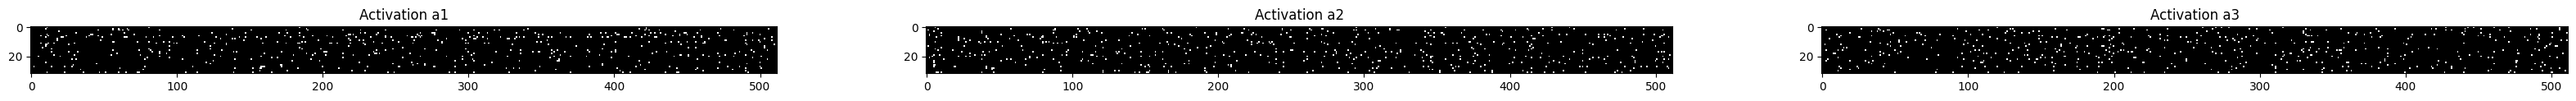

In [9]:
a1 = outputs['2']; a2 = outputs['5']; a3 = outputs['8']

plt.figure(figsize=(40, 30))

# Plot for a1
plt.subplot(1, 3, 1)
plt.imshow(a1.abs() > 0.97, cmap='gray', interpolation='nearest')
plt.title('Activation a1')

# Plot for a2
plt.subplot(1, 3, 2)
plt.imshow(a2.abs() > 0.97, cmap='gray', interpolation='nearest')
plt.title('Activation a2')

# Plot for a3
plt.subplot(1, 3, 3)
plt.imshow(a3.abs() > 0.97, cmap='gray', interpolation='nearest')
plt.title('Activation a3')

plt.show()

layer 1 (        a1): mean +0.00, std 0.61, saturated: 3.24%
layer 2 (        a2): mean -0.02, std 0.62, saturated: 3.42%
layer 2 (        a3): mean -0.00, std 0.62, saturated: 3.27%


Text(0.5, 1.0, 'activation distribution')

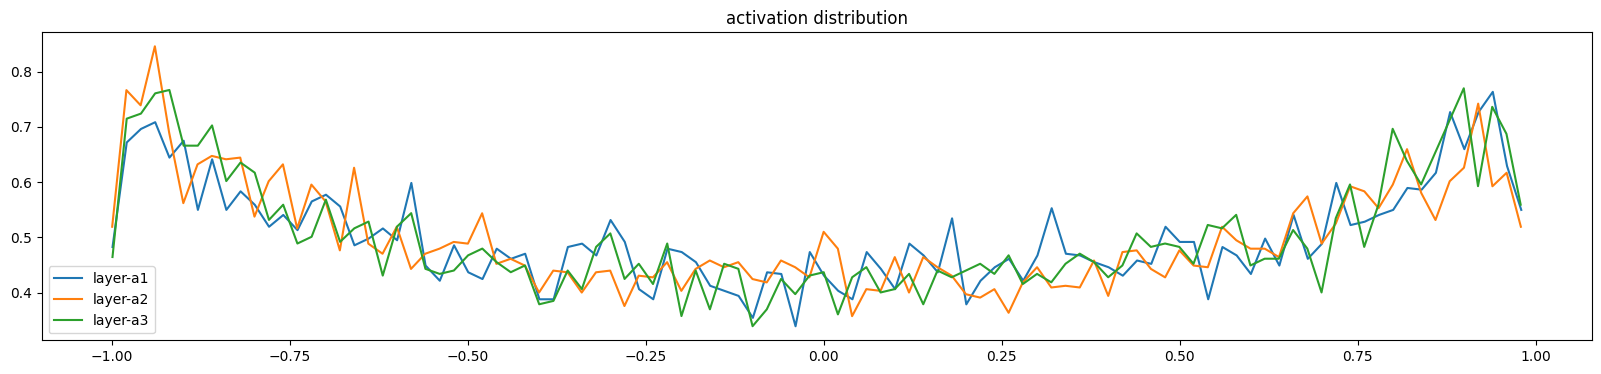

In [10]:
plt.figure(figsize=(20, 4))

hy, hx = torch.histogram(a1, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (1, 'a1', a1.mean(), a1.std(), (a1.abs() > 0.97).float().mean()*100))

hy, hx = torch.histogram(a2, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (2, 'a2', a2.mean(), a2.std(), (a2.abs() > 0.97).float().mean()*100))

hy, hx = torch.histogram(a3, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (2, 'a3', a3.mean(), a3.std(), (a3.abs() > 0.97).float().mean()*100))

plt.legend(['layer-a1', 'layer-a2', 'layer-a3'])
plt.title('activation distribution')

layer 1 (a1gradients): mean -0.000000, std 2.108246e-03
layer 2 (a2gradients): mean -0.000000, std 1.908662e-03
layer 3 (a2gradients): mean +0.000000, std 1.780224e-03


Text(0.5, 1.0, 'activation distribution')

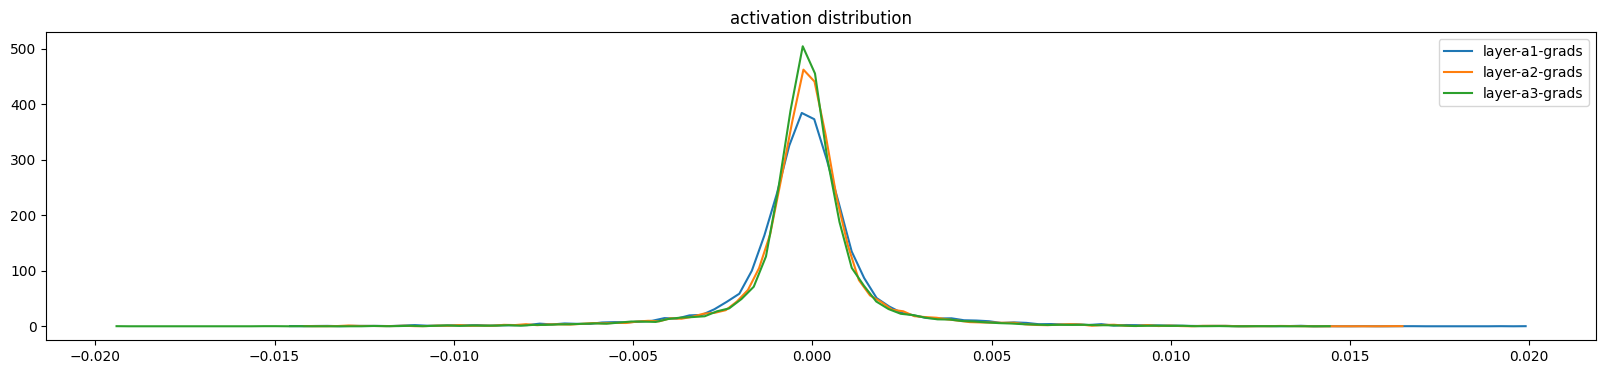

In [11]:
t1 = gradients['2']; t2 = gradients['5']; t3 = gradients['8']

plt.figure(figsize=(20, 4))

hy, hx = torch.histogram(t1, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
print('layer %d (%10s): mean %+f, std %e' % (1, 'a1gradients', t1.mean(), t1.std()))

hy, hx = torch.histogram(t2, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
print('layer %d (%10s): mean %+f, std %e' % (2, 'a2gradients', t2.mean(), t2.std()))

hy, hx = torch.histogram(t3, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
print('layer %d (%10s): mean %+f, std %e' % (3, 'a2gradients', t3.mean(), t3.std()))

plt.legend(['layer-a1-grads', 'layer-a2-grads', 'layer-a3-grads'])
plt.title('activation distribution')

#plt.xlim(-0.01, 0.01)